**Connect to drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


**Preprocessing**

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import *
from keras.regularizers import L2
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from keras.callbacks import ModelCheckpoint
from keras.models import Model, model_from_json


class Videoto3D:
    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=True):
        
        cap = cv2.VideoCapture(filename)
        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        
        if skip:
            frames = [int(x * nframe / self.depth) for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        
        framebuffer = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
        
            frame = cv2.resize(frame, (self.height, self.width))
        
            if color:
                framebuffer.append(frame)
            else:
                framebuffer.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        return np.array(framebuffer)
      
    def get_UCF_classname(self, file_path):
        filename = file_path.split("/")[-1]
        return filename[filename.find("_", 1) + 1:filename.find('_', 2)]


def plot_history(history, result_dir, model_name):
    fig1 = plt.figure()
    plt.plot(history.history['accuracy'], marker='.')
    plt.plot(history.history['val_accuracy'], marker='.')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
    plt.savefig(os.path.join(result_dir, model_name + '_accuracy.png'))
    
    fig2 = plt.figure()
    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.savefig(os.path.join(result_dir, model_name + '_loss.png'))
    
    plt.tight_layout()
    plt.show()


def model_save(model, path):
    model_json = model.to_json()

    with open(path + ".json", "w") as json_file:
        json_file.write(model_json)

    model.save_weights(path + ".h5")


def model_load(path):
    json_file = open(path + ".json", 'r')

    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    loaded_model.load_weights(path + ".h5")
    return loaded_model

def load_data(dataset_path, vid3d, color=False, X_path=None):
    video_names = os.listdir(dataset_path)
    video_paths = []

    for vname in video_names:
      for id, label in enumerate(classes):
        if f"_{label}_" in vname:
          video_paths.append(dataset_path + vname)

    labels = [classes.index(vid3d.get_UCF_classname(video_path)) for video_path in video_paths]
    
    if X_path is not None:
      X = np.load(X_path)
      return X, labels
    else:
      X = [vid3d.video3d(video_path) for video_path in video_paths]
    
    return np.array(X), labels


def data_preprocessing(X_train, X_test):  
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    return X_train, X_test


**The reading of the dataset**

In [3]:
# The selected class labels in the UCF-101 dataset
classes = ["TableTennisShot", "TennisSwing", "Punch", "Rafting", "Surfing"]
# project working directory
base_path = "/content/drive/project/"
# The address of the UCF-101 dataset 
dataset_path = f"{base_path}dataset/UCF101/"

height, width  = 224, 224
frames  = 10
num_classes = 5
epoch = 30
num_batch = 12
is_color = False
channel = 3 if is_color else 1

# Due to the time-consuming nature of data preprocessing, 
# it should be read from storage if it has been previously saved; 
# if there is no save, it should be saved.
is_there_save = FalsEe
x_path = if is_there_save f"{base_path}x.npy" else None 

vid3d = Videoto3D(height, width, frames)
x, y = load_data(dataset_path, vid3d, is_color, x_path)

if not is_there_save: 
    np.save(x_path, x) 

**Data Preprocessing**

In [7]:
x = x.transpose((0, 2, 3, 1))
X = x.reshape((*x.shape, channel)).astype('float32')

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Y_train_enc = np_utils.to_categorical(Y_train, num_classes)
Y_test_enc = np_utils.to_categorical(Y_test, num_classes)
X_train, X_test = data_preprocessing(X_train, X_test)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("Y_train: ", Y_train_enc.shape)
print("Y_test: ", Y_test_enc.shape)

X_train:  (562, 224, 224, 10, 1)
X_test:  (141, 224, 224, 10, 1)
Y_train:  (562, 5)
Y_test:  (141, 5)


**3DCNN Model Architecture**

In [ ]:
model = Sequential()

# 3D Convolutional Layers
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1:])))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

# Dense layers with regularization
model.add(Dense(256, activation='relu', kernel_regularizer=L2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=L2(0.01)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 224, 224, 10, 32)  896       
                                                                 
 conv3d_25 (Conv3D)          (None, 224, 224, 10, 32)  27680     
                                                                 
 batch_normalization_12 (Bat  (None, 224, 224, 10, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 112, 112, 5, 32)  0         
 g3D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 112, 112, 5, 32)   0         
                                                                 
 conv3d_26 (Conv3D)          (None, 112, 112, 5, 64)  

**Train**

In [ ]:
# 20% of the training dataset is used for validation.
history = model.fit(X_train, Y_train_enc, epochs=epoch, batch_size=num_batch, verbose=1, validation_split=0.2, shuffle=True)


model.evaluate(X_test, Y_test_enc, verbose=0)
model_json = model.to_json()

loss, acc = model.evaluate(X_test, Y_test_enc, verbose=0)
# Weight folder should be in the working directory to save the model
model_name = f"3dcnnmodel_{epoch}"
model_save(model, f"{base_path}weights/{model_name}")

print('Test loss:', loss)
print('Test accuracy:', acc)

Epoch 1/30
38/38 [==============================] - 45s 1s/step - loss: 12.6680 - accuracy: 0.5100 - val_loss: 22.0311 - val_accuracy: 0.3805
Epoch 2/30
38/38 [==============================] - 44s 1s/step - loss: 8.7468 - accuracy: 0.6748 - val_loss: 8.0890 - val_accuracy: 0.4425
Epoch 3/30
38/38 [==============================] - 44s 1s/step - loss: 6.7672 - accuracy: 0.7483 - val_loss: 6.9698 - val_accuracy: 0.6106
Epoch 4/30
38/38 [==============================] - 44s 1s/step - loss: 5.5657 - accuracy: 0.7906 - val_loss: 6.2075 - val_accuracy: 0.6018
Epoch 5/30
38/38 [==============================] - 44s 1s/step - loss: 4.8349 - accuracy: 0.8129 - val_loss: 4.8968 - val_accuracy: 0.7345
Epoch 6/30
38/38 [==============================] - 44s 1s/step - loss: 4.0064 - accuracy: 0.8530 - val_loss: 5.4702 - val_accuracy: 0.6106
Epoch 7/30
38/38 [==============================] - 44s 1s/step - loss: 3.6000 - accuracy: 0.8307 - val_loss: 4.1386 - val_accuracy: 0.7168
Epoch 8/30
38/38 [

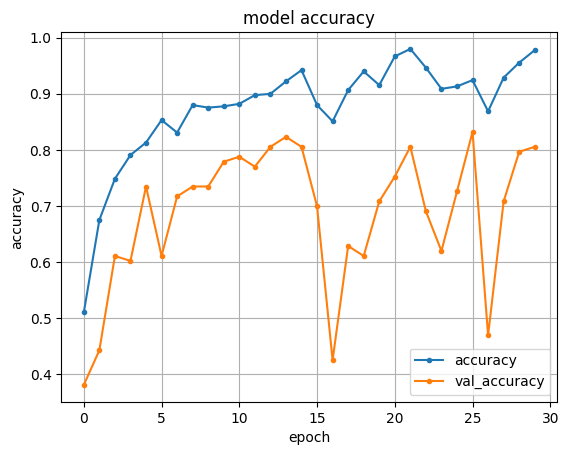

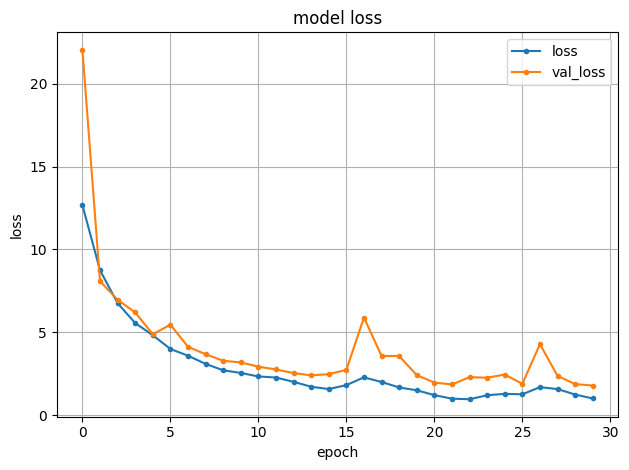

In [ ]:
plot_history(history, f"{base_path}result", model_name)

**Confusion Matrix Visualization**

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def display_confusion_mat(model, X_test, Y_test, labels=classes):
  Y_pred = model.predict(X_test)
  Y_pred_classes = Y_pred.argmax(1)
  cm = confusion_matrix(Y_test, Y_pred_classes)
  
  # Confusion matrixi gorsellestirme
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt='.1f', xticklabels=labels, yticklabels=labels)
  

**Load the trained model and test**

model confusion matrix:
Test size | input: (141, 224, 224, 10, 1) -- label: 141
5/5 [==============================] - 3s 653ms/step


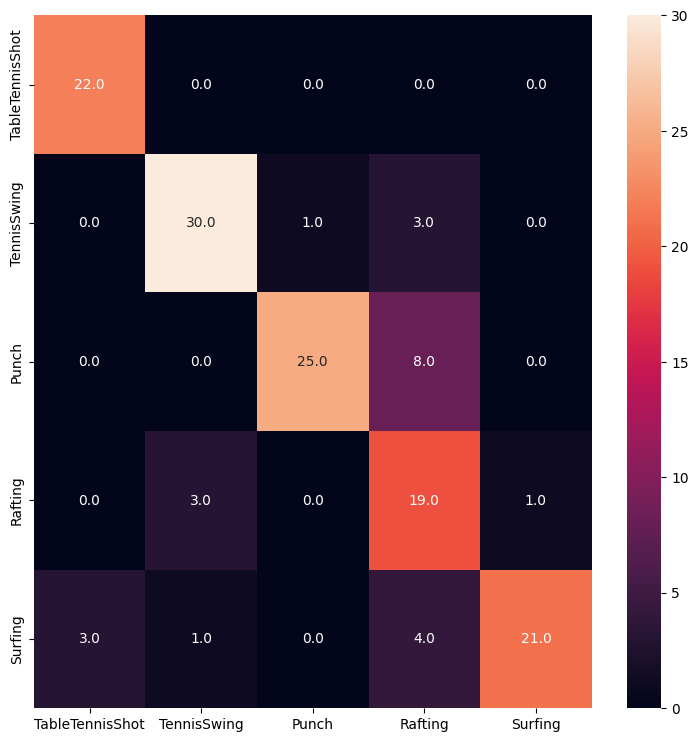

In [10]:
model_name = f"3dcnnmodel_{epoch}"
loaded_model = model_load(f"{base_path}weights/{model_name}")

print("model confusion matrix:")
print(f"Test size | input: {X_test.shape} -- label: {len(Y_test)}")
display_confusion_mat(loaded_model, X_test, Y_test)

**Observe model predictions on test samples**

In [11]:
from PIL import Image

# The "result" folder should be in the working directory to save the test results
model_name = f"3dcnnmodel_{epoch}"
result_path = f"{base_path}result/3dcnn"

model = model_load(f"{base_path}weights/{model_name}")

labels = classes

def test_img_selection():
  selected = {}
  counter = 0

  # Four examples are taken from each class
  for i in range(len(X_test)):
    x,y = X_test[i], Y_test[i]

    if y in selected.keys(): 
      if len(selected[y]) < 4:
        selected[y].append(x)
        counter += 1
        if len(selected[y]) == 4:
          selected[y] = np.array(selected[y])
    elif counter >= 4 * len(labels):
      break
    else:
      selected[y] = [x]
    
  return selected


test_data = test_img_selection()
result = []
result_txt = open(f"{result_path}/{model_name}.txt", "w")  

all_predictions = None
all_labels = []

for label_i in range(len(labels)):
  label = labels[label_i]
  print(label)
  y_pred = model.predict(test_data[label_i])
  
  if all_predictions is None:
    all_predictions = y_pred
  else:
    all_predictions = np.concatenate((all_predictions, y_pred), axis=0)

  for i in range(4):
    all_labels.append([label_i])

    y = y_pred[i]
    max_args = np.flip(y.argsort())[:5]             # List the indices according to the maximum and minimum score values.
    result.append([labels[i] for i in max_args])
    result.append([y[i] for i in max_args])

    result_txt.write(str(result) + "\n")            # Save the results to a text file and save the selected example images.
    test_trans = test_data[label_i][i].transpose((2, 0, 1, 3))
    Image.fromarray((np.resize(test_trans[5], (224, 224)) * 255).astype(np.uint8)).save(f"{result_path}/{label}_{str(i)}.jpg")
    
    print(result)
    result = []

result_txt.close()

print(all_predictions.shape)

TableTennisShot
1/1 [==============================] - 2s 2s/step
[['TableTennisShot', 'Punch', 'TennisSwing', 'Rafting', 'Surfing'], [0.99952126, 0.00046900928, 8.6362e-06, 8.9731594e-07, 1.9433969e-07]]
[['TableTennisShot', 'Punch', 'Surfing', 'Rafting', 'TennisSwing'], [0.9996489, 0.0003398924, 8.12286e-06, 1.6014229e-06, 1.3745029e-06]]
[['TableTennisShot', 'Punch', 'TennisSwing', 'Surfing', 'Rafting'], [0.9999896, 7.0668557e-06, 1.96299e-06, 1.4461654e-06, 4.6484487e-09]]
[['TableTennisShot', 'Surfing', 'Punch', 'Rafting', 'TennisSwing'], [0.98797333, 0.011087597, 0.00054652063, 0.0002896292, 0.00010281852]]
TennisSwing
1/1 [==============================] - 0s 44ms/step
[['TennisSwing', 'Punch', 'TableTennisShot', 'Rafting', 'Surfing'], [0.99999416, 4.466894e-06, 1.3703865e-06, 4.250337e-08, 1.9189346e-10]]
[['TennisSwing', 'TableTennisShot', 'Surfing', 'Punch', 'Rafting'], [0.9726888, 0.01584675, 0.010296445, 0.000987905, 0.00018008715]]
[['TennisSwing', 'TableTennisShot', 'Punc